## GAN Example to generate MNIST data
- Ref - https://github.com/malhamid/GAN_MNIST/blob/master/GAN_MNIST.ipynb

In [23]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU

### Constant

In [20]:
INPUT_SHAPE = (28, 28, 1)
NOISE_DIM = 100
EPOCHS = 100
BATCH_SIZE = 256

### Load Dataset

In [3]:
# Train -- (60000, 28, 28), (60000, )
# Test -- (10000, 28, 28), (10000, )
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### Data Preprocessing

In [4]:
# (N, 28, 28) => (N, 28*28)
X_train = np.reshape(X_train, (X_train.shape[0], 28 * 28)) / 255.0
X_test = np.reshape(X_test, (X_test.shape[0], 28 * 28)) / 255.0

### Data Generator

In [10]:
def generate_real_img(n_samples):
    x_real = X_train[np.random.randint(0, X_train.shape[0], n_samples)]
    x_real = np.reshape(x_real, (n_samples, 28, 28, 1))
    y_real = np.ones((n_samples, 1))

    return x_real, y_real

In [9]:
def generate_img_using_model(generator, n_samples):
    noise = np.random.randn(n_samples, NOISE_DIM)

    x_fake = generator.predict(noise)
    y_fake = np.zeros((n_samples, 1))

    return x_fake, y_fake

### Create Model

In [5]:
# Discriminator
def building_discriminator():
    model_d = Sequential()
    # Layer 1
    model_d.add(Conv2D(64, 3, 2, input_shape=INPUT_SHAPE))
    model_d.add(LeakyReLU())
    model_d.add(Dropout(0.4))

    # Layer 2
    model_d.add(Conv2D(64, 3, 2))
    model_d.add(LeakyReLU())
    model_d.add(Dropout(0.4))

    # Final Classification Layer
    model_d.add(Flatten())
    model_d.add(Dense(1, activation='sigmoid'))

    # Compile
    model_d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model_d

In [19]:
# Generator
def building_generator():
    model_g = Sequential()
    # Layer 1
    model_g.add(Dense(128*6*6, input_shape=(NOISE_DIM, )))
    model_g.add(LeakyReLU())
    model_g.add(Reshape((6, 6, 128)))

    # Layer 2
    model_g.add(Conv2DTranspose(128, (4, 4), (2, 2)))
    model_g.add(LeakyReLU())

    # Layer 3
    model_g.add(Conv2DTranspose(128, (4, 4), (2, 2)))
    model_g.add(LeakyReLU())
    model_g.add(Conv2D(1, (3, 3), activation='sigmoid'))

    return model_g    

In [7]:
def building_gan(generator, discriminator):
    gan = Sequential()
    discriminator.trainable = False

    gan.add(generator)
    gan.add(discriminator)
    gan.compile(loss='binary_crossentropy', optimizer='adam')

    return gan

In [21]:
# Create GAN Model
gen = building_generator()
dis = building_discriminator()
gan = building_gan(gen, dis)
gan.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         991105    
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 39873     
Total params: 1,030,978
Trainable params: 991,105
Non-trainable params: 39,873
_________________________________________________________________


### Train Model

In [27]:
def training_gan(gan_model, discriminator, generator, batch_size=256, epochs=100):
    for epoch in range(epochs):
        for step in range(X_train.shape[0] // batch_size):
            # Get real and fake image data
            X_real, y_real = generate_real_img(batch_size)
            X_fake, y_fake = generate_img_using_model(generator, batch_size)

            # Concatenate to get training data
            X_batch = np.concatenate([X_real, X_fake], axis=0)
            y_batch = np.concatenate([y_real, y_fake], axis=0)

            # Train discriminator
            d_loss, d_acc = discriminator.train_on_batch(X_batch, y_batch)

            # Generate noise input for GAN training
            X_gan = np.random.randn(batch_size, NOISE_DIM)
            y_gan = np.ones((batch_size, 1))

            # Train GAN (With fixed discriminator)
            gan_loss = gan_model.train_on_batch(X_gan, y_gan)

        # Print loss info at each epoch end
        print('Training progress in epoch #%d, discriminator loss=%.3f , generator loss=%.3f' % (epochs ,d_loss, gan_loss))

In [ ]:
training_gan(gan, dis, gen, BATCH_SIZE, EPOCHS)

### Evaluation

In [14]:
# Evaluate Discriminator
X_real, y_real = generate_real_img(BATCH_SIZE)
_, acc_real = dis.evaluate(X_real, y_real)
print(acc_real)

8/8 [==============================] - 0s 5ms/step - loss: 0.7167 - accuracy: 0.1172
0.1171875


In [22]:
# Evaluate Generator / Discriminator
X_fake, y_fake = generate_img_using_model(gen, BATCH_SIZE)
_, acc_fake = dis.evaluate(X_fake, y_fake)
print(acc_fake)

8/8 [==============================] - 0s 5ms/step - loss: 0.7069 - accuracy: 0.0000e+00
0.0


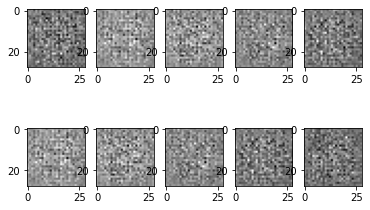

In [25]:
# Visualize generator result
X_test = np.random.randn(10, NOISE_DIM)
X_fake = gen.predict(X_test)

fig, axs = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):  
        axs[i,j].imshow(np.reshape(X_fake[i+j], (28,28)), cmap='binary')